# DSCI 100 Group 84 Project
### Alyssa Aguason, Russell Ly, Sam Tong, Eric Yee

## Introduction

Auditing is the process of conducting evaluations on the financial statements of an organization in order to identify the accuracy of their financial records. It can be conducted by the organization itself, but is more commonly done by an outside Certified Public Account (CPA) firm. An external investigation is done by using quantitative financial data, and an internal investigation follows if the firm is suspected to be committing fraud. The external process is a timely task that could be improved by use of a classification model. In view of this, we are interested in creating an accurate model that is able to quickly identify fraudulent firms, based on a small amount of financial data, to speed up this external auditing process. Thus, our question is **"Can we build a classification model that will predict a firm’s risk of fraud and find whether or not this model would be accurate enough to use in an external auditing process?"**

In this study, we will build, train, and test a classification model based on financial risk data of Indian firms. The data we are using in this study were collected by the Comptroller and Auditor General (CAG) of India for a total of 777 firms in the year 2015. The dataset contains observations of financial data that auditors use during the external investigation. Note that some predictive columns are already scaled, exceptions being the columns “PARA_A”, “PARA_B”, “TOTAL”, and “Money_Value”.

## Methods and Results

In [1]:
library(repr)
library(tidyverse)
library(tidymodels)
set.seed(1000)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [2]:
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00475/audit_data.zip"
destfile <- "audit.zip"
download.file(url, destfile)

unzip("audit.zip", list = TRUE)

Name,Length,Date
<chr>,<dbl>,<dttm>
audit_data/audit_risk.csv,81197,2018-07-14 13:04:00
audit_data/trial.csv,39965,2018-07-14 12:47:00


#### Table 1: The Two .csv Files from the Source
`trial.csv` has just the data with no evaluation scores from the original data collector's own models, so that is what we will use in this project.

In [3]:
audit_data <- read_csv(unzip("audit.zip", "audit_data/trial.csv")) |>
    mutate(Risk = as_factor(Risk))
head(audit_data)

Rows: 776 Columns: 18
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): LOCATION_ID
dbl (17): Sector_score, PARA_A, SCORE_A, PARA_B, SCORE_B, TOTAL, numbers, Ma...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Sector_score,LOCATION_ID,PARA_A,SCORE_A,PARA_B,SCORE_B,TOTAL,numbers,Marks,Money_Value,MONEY_Marks,District,Loss,LOSS_SCORE,History,History_score,Score,Risk
<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
3.89,23,4.18,6,2.50,2,6.68,5,2,3.38,2,2,0,2,0,2,2.4,1
3.89,6,0.00,2,4.83,2,4.83,5,2,0.94,2,2,0,2,0,2,2.0,0
3.89,6,0.51,2,0.23,2,0.74,5,2,0.00,2,2,0,2,0,2,2.0,0
3.89,6,0.00,2,10.80,6,10.80,6,6,11.75,6,2,0,2,0,2,4.4,1
3.89,6,0.00,2,0.08,2,0.08,5,2,0.00,2,2,0,2,0,2,2.0,0
3.89,6,0.00,2,0.83,2,0.83,5,2,2.95,2,2,0,2,0,2,2.0,0


#### Table 2: The First Few Rows from the Dataset

In [4]:
audit_prop <- audit_data |>
    group_by(Risk) |>
    summarize(count = n())
audit_prop

Risk,count
<fct>,<int>
0,290
1,486


#### Table 3: Number of Non-Fraudulent Businesses (Risk = 0) and Fraudulent Businesses (Risk = 1) in the dataset
290 of the businesses in the dataset were not detected of fraud, while 486 of the businesses were.

In [5]:
audit_split <- initial_split(audit_data, prop = 0.75, strata = Risk)
audit_train <- training(audit_split)
audit_test <- testing(audit_split) |>
    filter(Money_Value != "NA") 
    # One of the observations with a value of NA was causing issues later on

mean_train <- audit_train |>
    group_by(Risk) |>
    summarize(mean_para_a = mean(PARA_A),
              mean_para_b = mean(PARA_B),
              mean_money_value = mean(Money_Value, na.rm = TRUE))
mean_train

Risk,mean_para_a,mean_para_b,mean_money_value
<fct>,<dbl>,<dbl>,<dbl>
0,0.2876959,0.2527912,0.3009862
1,3.8406885,18.8677473,24.2730769


#### Table 4: Training Data Summary Table
Table 4 outlines the average (mean) values of each variable we are using from the training data, separated by Risk (0 for businesses not detected of fraud, 1 for businesses detected of fraud). Non-fraudulent businesses have much smaller values compared to the fraudulent businesses.

#### Method

In our study, we will use the K-nearest neighbors classification model to best predict whether an Indian business firm is fraudulent based on 3 inherent risk factors. We chose these variables:
- PARA_A and PARA_B: the difference between planned and unplanned expenditures of a company versus the actual expenditures auditors discover, respectively
- Money_Value: the amount of money involved in misstatements in past audits

We choose the 3 inherent risk factors variables because a large gap between a company's reported and actual financial status can indicate that a company is not disclosing practices. We decided not to use any control risk factors because they were qualitatively assigned by auditors during the external report and subjective in that way. In the goal of creating a model to lessen the work of auditors, we are only using the quantitative values that are given.

We will conduct a cross-validation on the initial model to find the number of nearest neighbors that yields the highest accuracy. It will then be fitted to the training data, and we will test the model’s accuracy using the testing data.

Our final visualization will be a bar graph with two bars, each bar representing firms detected/not detected of fraud with a certain portion of them coloured in to indicate the portion of firms with their fraud status correctly predicted by our model. We will also visualize the data in a 2x2 confusion matrix, revealing the accuracy of our model on the test data.

In [6]:
options(repr.plot.width = 18, repr.plot.height = 8)

select_audit_train <- audit_train |>
    select(c(Risk, PARA_A, PARA_B, Money_Value)) |>
    filter(PARA_A < 40, PARA_B < 125, Money_Value < 350) # high-value outliers removed for visual clarity and less empty space 

para_A <- ggplot(select_audit_train, aes(x = PARA_A, fill = Risk)) +
    geom_histogram(binwidth = 1.5) +
    xlab("Discrepency between Planned Expidentures and Summary Reports in Rupees (in crore)") +
    ylab("Number of Firms") +
    labs(fill = "Business Status") +
    scale_fill_discrete(labels=c("Not Detected of Fraud", "Detected of Fraud")) +
    facet_grid(cols = vars(Risk)) +
    theme(text = element_text(size = 20))

para_B <- ggplot(select_audit_train, aes(x = PARA_B, fill = Risk)) +
    geom_histogram(binwidth = 5) +
    xlab("Discrepency between Unplanned Expidentures and Summary Reports in Rupees (in crore)") +
    ylab("Number of Firms") +
    labs(fill = "Business Status") +
    scale_fill_discrete(labels=c("Not Detected of Fraud", "Detected of Fraud")) +
    facet_grid(cols = vars(Risk)) +
    theme(text = element_text(size = 20))

money_value <- ggplot(select_audit_train, aes(x = Money_Value, fill = Risk)) +
    geom_histogram(binwidth = 5) +
    xlab("Amount of Money Involved in Misstatements in Past Audits in Rupees (in crore)") +
    ylab("Number of Firms") +
    labs(fill = "Business Status") +
    scale_fill_discrete(labels=c("Not Detected of Fraud", "Detected of Fraud")) +
    facet_grid(cols = vars(Risk)) +
    theme(text = element_text(size = 20))

Figure 1, Figure 2 and Figure 3 display the distribution of values of the three variables we used to predict whether a business is detected of fraud. There are few columns in most of the graphs with a Risk score of 0 because there is often little/no discrepency found in the audit reports for businesses not detected of fraud.

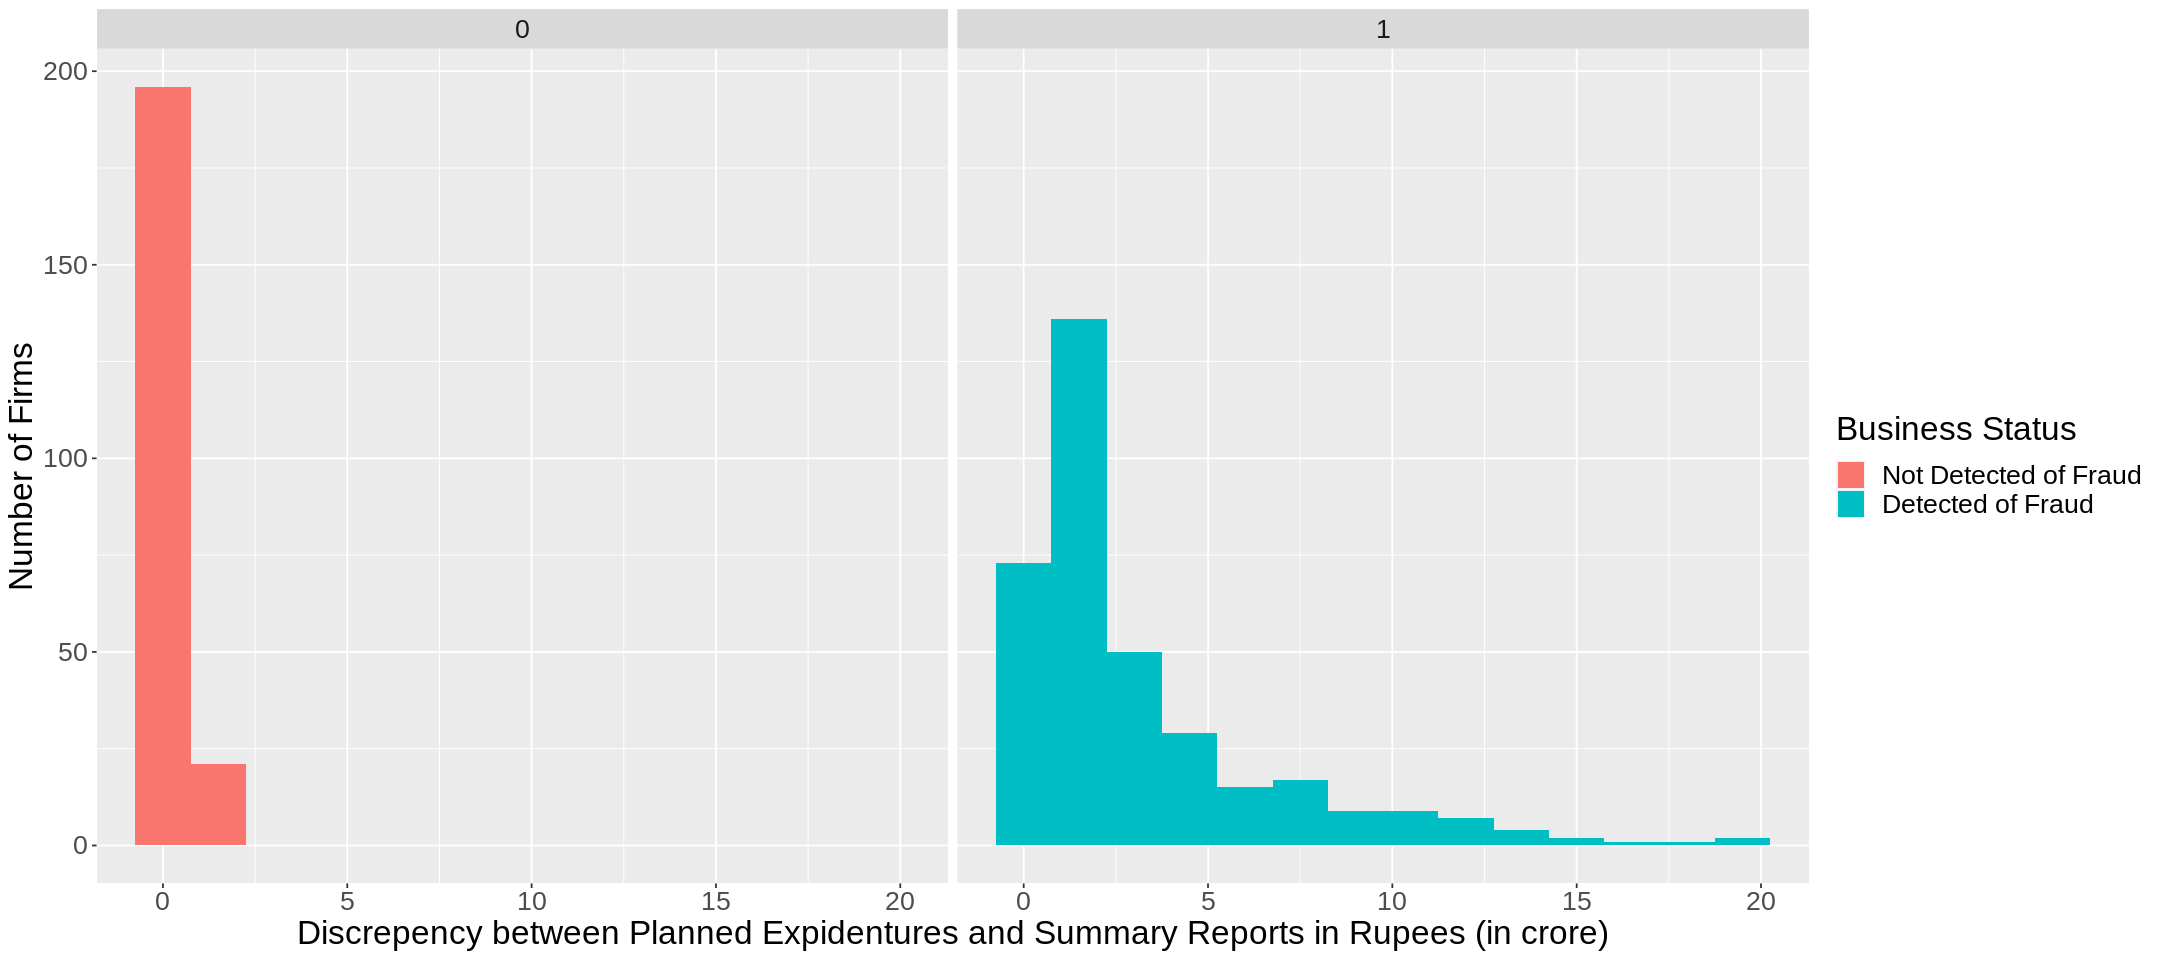

In [7]:
para_A

#### Figure 1: Para A

All of the businesses not detected of fraud had little to no discrepancy between planned expenditures and summary reports, while most of the businesses detected of fraud had at least a small discrepancy.

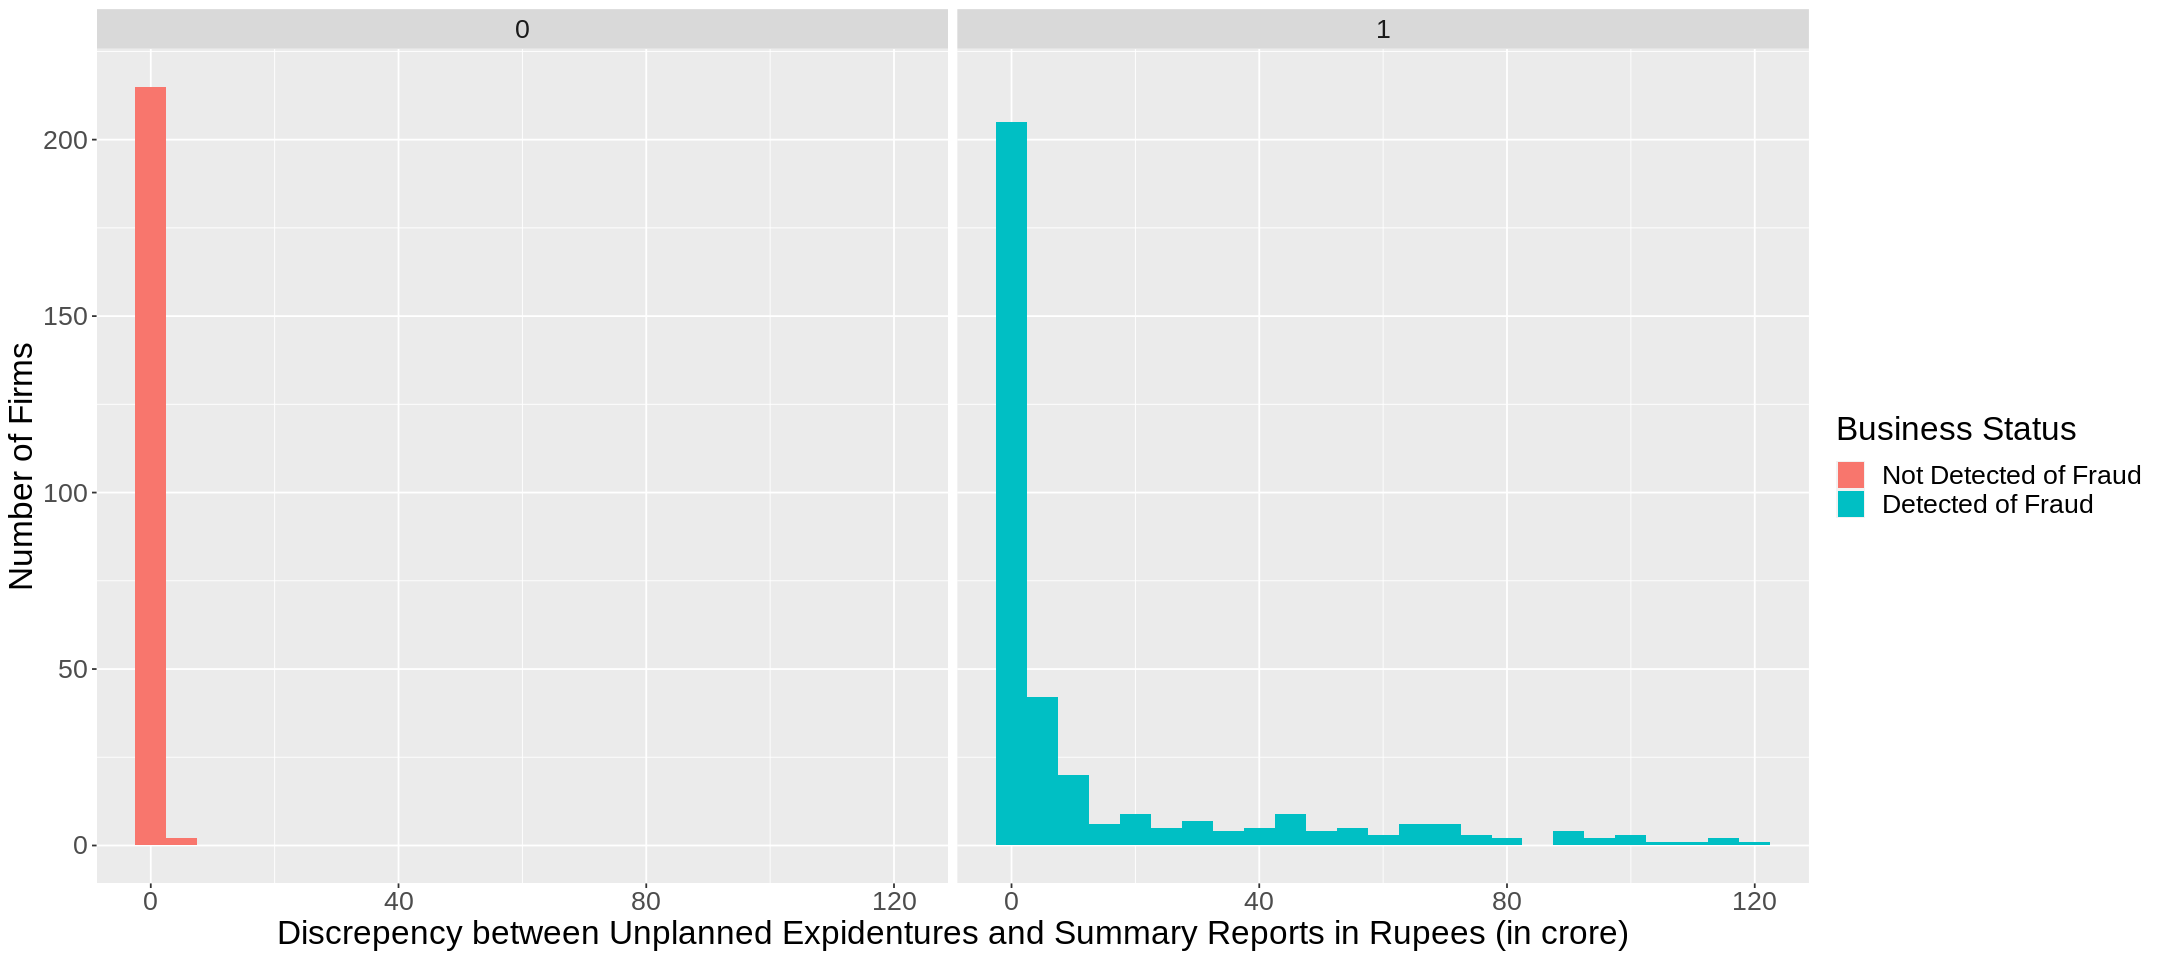

In [8]:
para_B

#### Figure 2: Para B
All of the businesses not detected of fraud had little to no discrepancy between unplanned expenditures and summary reports, while a good portion of the businesses detected of fraud had some significant level of discrepancy.

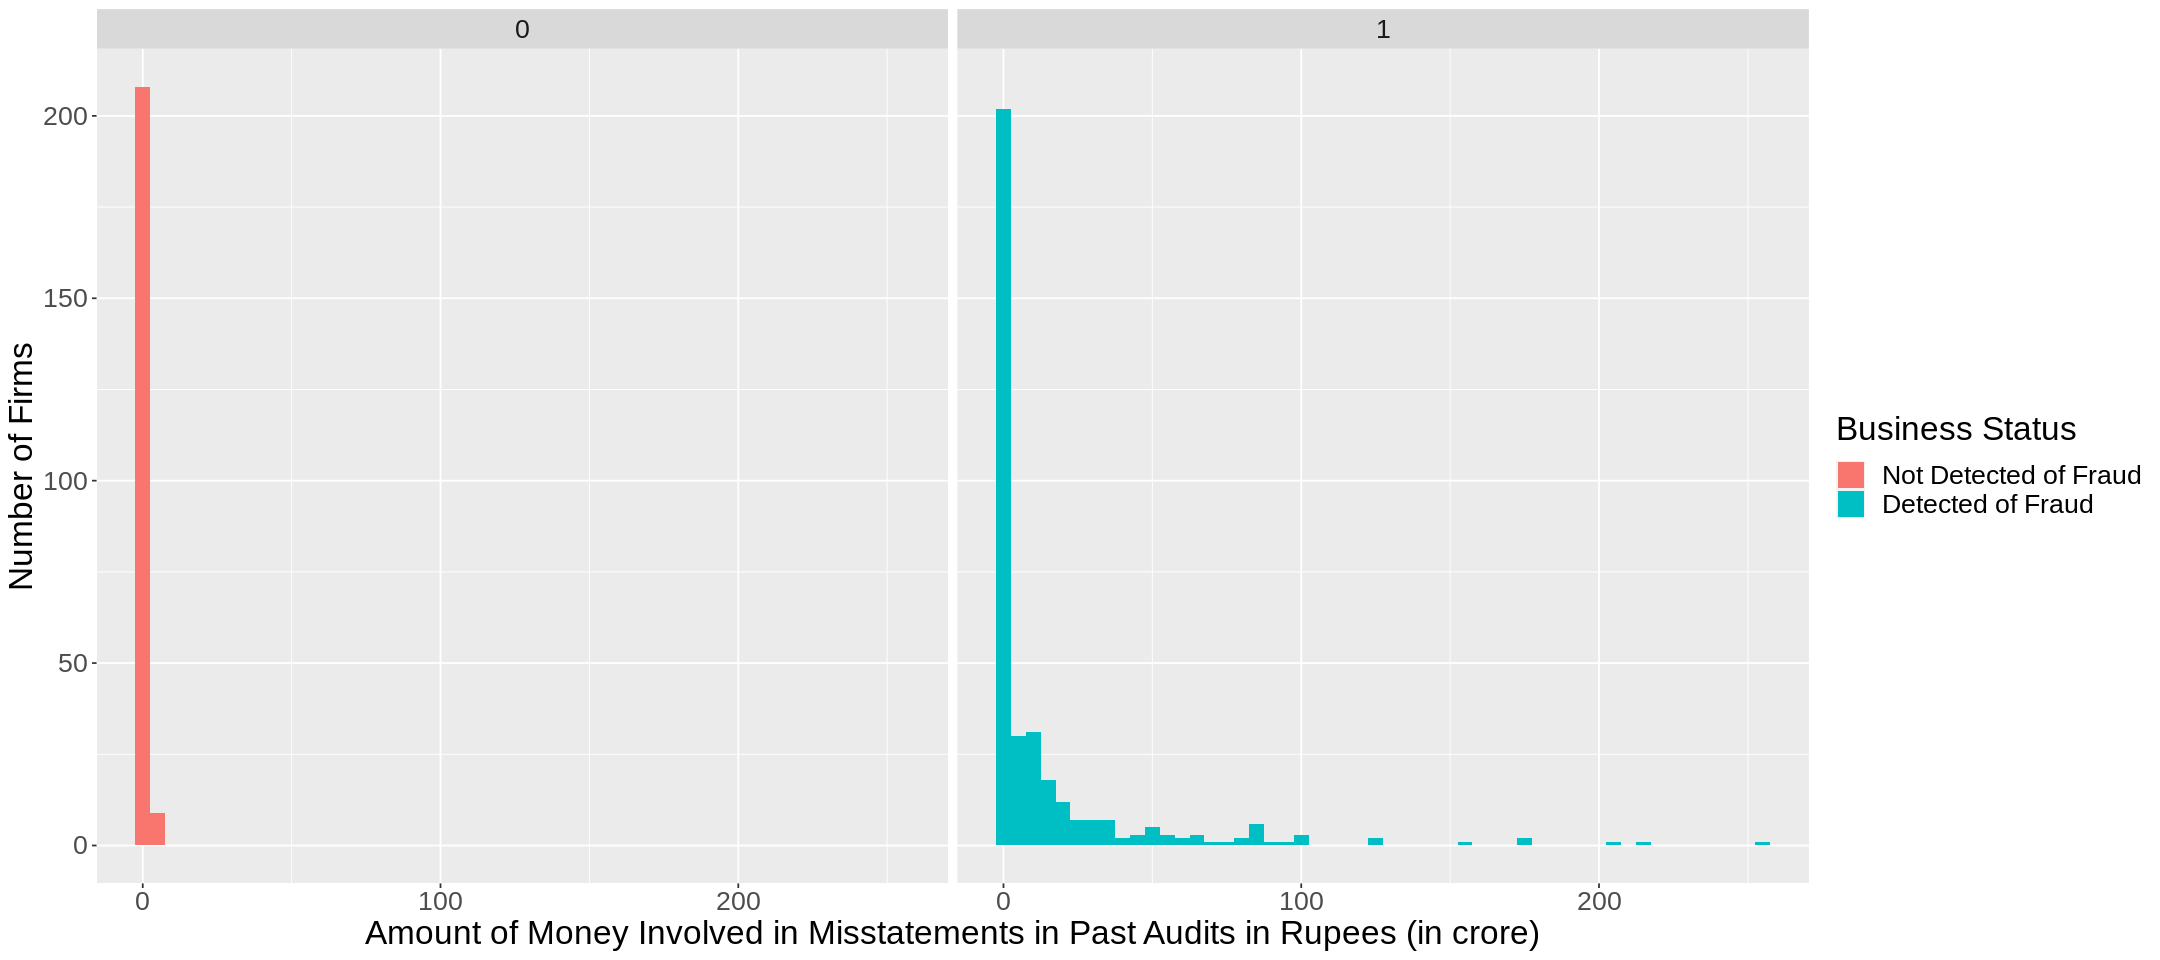

In [9]:
money_value

#### Figure 3: Money Value
All of the businesses not detected of fraud had very little to no money involved in misstatements in past audits, while some businesses detected of fraud had significant amounts of money involved in prior misstatements.

In [10]:
knn_recipe <- recipe(Risk ~ PARA_A + PARA_B + Money_Value, data = audit_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

audit_vfold <- vfold_cv(audit_train, v = 5, strata = Risk)

k_lots <- tibble(neighbors = seq(from = 1, to = 41, by = 2))
#only odd values of k are tested because even values may cause difficulties in assigning a class by the mode (could be evenly split)

knn_results <- workflow() |>
    add_recipe(knn_recipe) |>
    add_model(knn_tune) |>
    tune_grid(resamples = audit_vfold, grid = k_lots) |>
    collect_metrics()

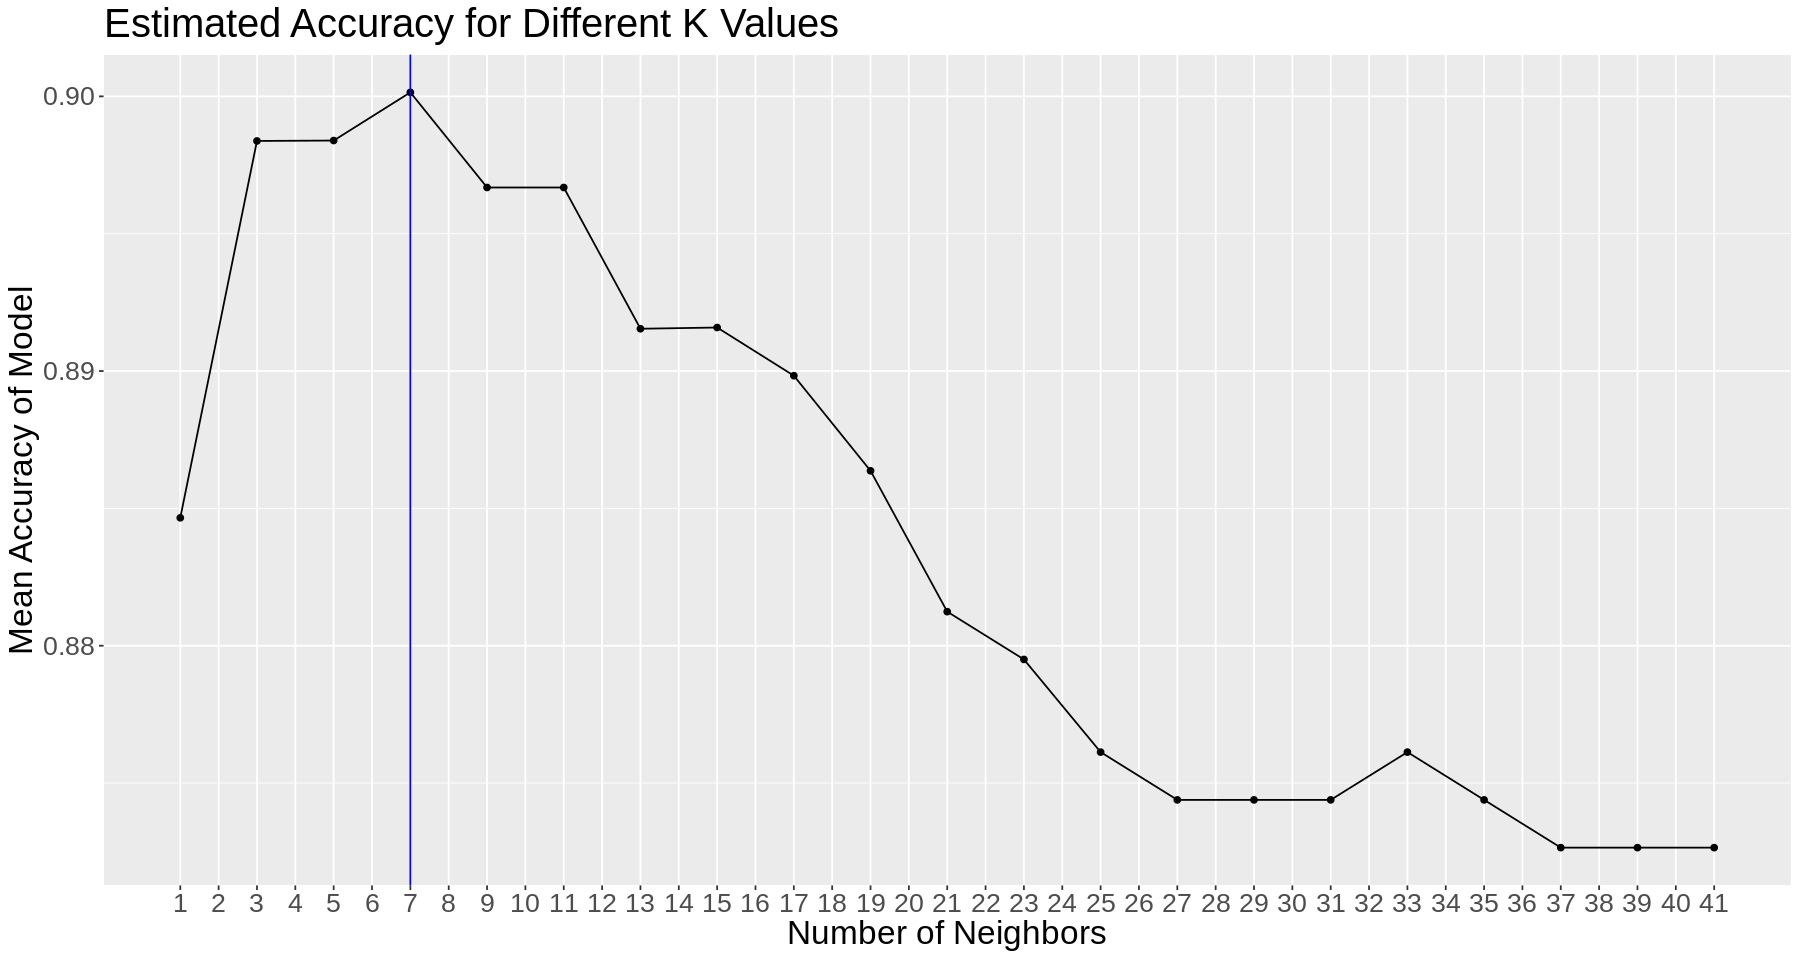

In [11]:
options(repr.plot.width = 15, repr.plot.height = 8)
cross_val_plot <- knn_results |> filter(.metric == "accuracy") |>
    ggplot(aes(x = neighbors, y = mean))+
        geom_point()+
        geom_line()+
        labs(x = "Number of Neighbors",
             y = "Mean Accuracy of Model",
             title = "Estimated Accuracy for Different K Values")+
        theme(text = element_text(size = 20)) +
        geom_vline(xintercept = 7, colour = "blue") +
        scale_x_continuous(limits = c(1, 41),
                       breaks = seq(from = 1, to = 41),
                       minor_breaks = seq(from = 1, to = 41, by = 2))

cross_val_plot

#### Figure 4: Cross Validation for k Nearest Neighbors
Figure 4 is the line plot of different K values from 1 to 41 and their mean accuracy. As expected, the accuracy of the model will increase with added neighbors (because overfitting is reduced), but eventually the accuracy will dip down as the model begins to underfit, so we choose the k where the estimated accuracy of the model peaks.

Since k = 7 gives the highest mean accuracy in the cross validation and is relatively stable given the y-axis scale, we will choose k = 7 for our final model.

In [12]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 7) |>
    set_engine("kknn") |>
    set_mode("classification")

knn_fit <- workflow() |>
    add_recipe(knn_recipe) |>
    add_model(knn_spec) |>
    fit(audit_train)

predictions <- predict(knn_fit, audit_test) |>
    bind_cols(audit_test)
metrics <- predictions |>
    metrics(truth = Risk, estimate = .pred_class)
conf_mat <- predictions |>
    conf_mat(truth = Risk, estimate = .pred_class)

options(repr.plot.width = 10, repr.plot.height = 6)
conf_mat_plot <- predictions |>
    ggplot(aes(x = Risk, fill = .pred_class))+
        geom_bar(position = "fill")+
        labs(x = "True Risk",
             fill = "Predicted Risk",
             y = "Proportion",
            title = "Classification Model Prediction Accuracy")+
        theme(text = element_text(size = 20))

In [13]:
metrics

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.9072165
kap,binary,0.8098868


#### Table 5: Accuracy Metrics
According to Table 5, our model with k = 7 has a 90.7% prediction accuracy.

In [14]:
conf_mat

          Truth
Prediction   0   1
         0  71  17
         1   1 105

#### Table 6: Confusion Matrix
According to Table 6, our model on the testing data made 71 correct predictions for non-fraudulent firms being non-fraudulent, 1 incorrect prediction for a non-fraudulent firm being fraudulent, 105 correct predictions for fraudulent firms being fraudulent, and 17 incorrect predictions for fraudulent firms being non-fraudulent. This means our model had a 98.6% accuracy for correctly predicting non-fraudulent firms and an 86.1% accuracy for correctly predicting fraudulent firms.

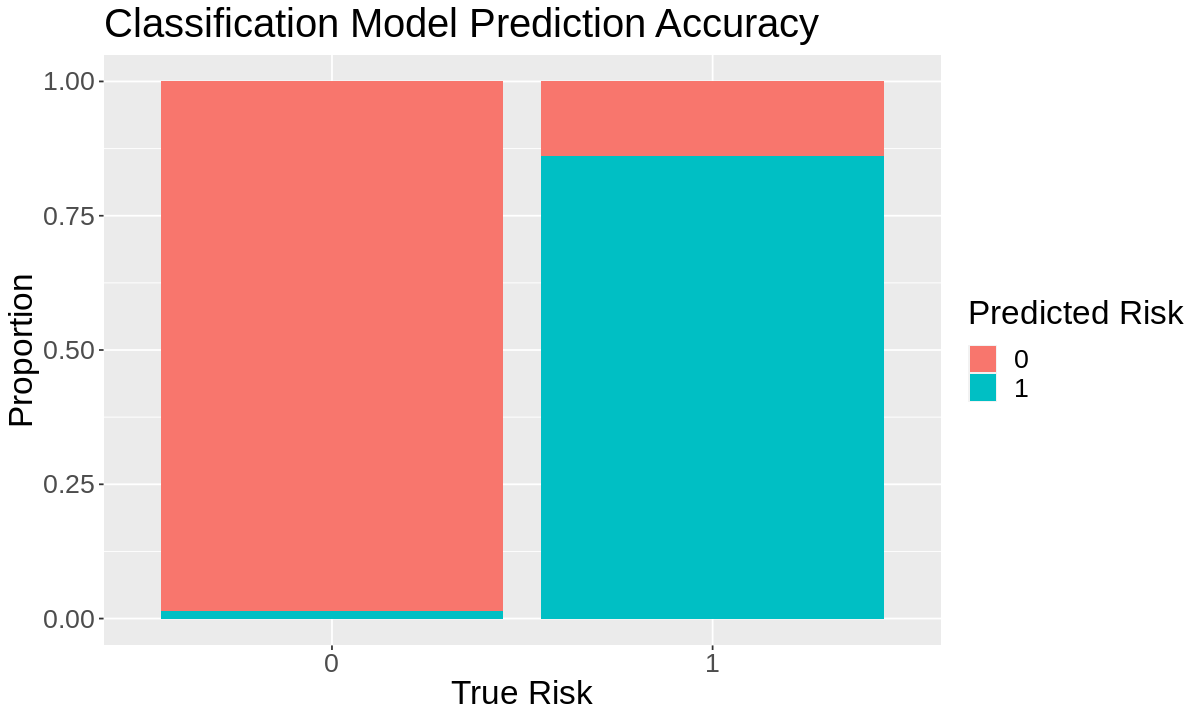

In [15]:
conf_mat_plot

#### Figure 5: Visualization of the Model's Accuracy

From Figure 5 we can see that the model is better at predicting firms that are not fraudulent, but in both categories, correct predictions greatly outweigh the incorrect ones.

## Discussion

In this study, we conducted a KNN-classification to create a computation model to predict whether an Indian firm is fraudulent, based on 3 different financial and non-financial aspects of the business. Our data covered 777 companies across 14 business sectors, which we used for training and testing our model. After training the model with a 75/25 training/test data split, we created a model that yields an accuracy of 90.7% as seen in Table 5. This means that 90.7% of the companies in our test data were correctly identified as fraudulent or non-fraudulent by our classification model. This high accuracy is an accurate representation of the true accuracy of the model because it is based on separate test data not used to train our classification model, thus not having been previously “seen” by the model. In addition, we also produced a confusion matrix (Table 6) for the result of the test data classification, providing further insights. The matrix visualization (Figure 5) shows that our classification model is better at classifying non-fraudulent firms than fraudulent firms, as there are much fewer non-fraudulent firms misidentified as fraudulent firms, compared to the number of fraudulent firms misidentified as non-fraudulent firms.

Overall, the result of our classification model meets our expectations. In this study, we hypothesized that the three inherent risk scores we selected, PARA_A, PARA_B and Money value, can be used as reliable predictor variables to accurately predict whether an Indian firm is fraudulent. Achieving a prediction accuracy of 90.7% indicates that most of the time, our model is able to correctly distinguish between fraudulent or non-fraudulent Indian firms with those three variables, and therefore, provides strong evidence for proving our hypothesis. The result might be explained by the high suitability of the three variables to be a predictor of firm fraud. Those three inherent risk scores represent the discrepancy between the financial status reported by firms and the actual financial status reported by auditors. A substantial discrepancy in any of the three variables would likely be a red flag of fraud because a discrepancy implies that a firm wants to hide its actual financial position. This may explain why our classification is able to predict if an Indian firm is fraudulent. However, while the high prediction accuracy of our model aligns with our expectations, the confusion matrix shows unexpected outcomes. We did not expect our model to be better at classifying non-fraudulent firms, as there is a larger amount of data on fraudulent firms in the dataset (Table 3), making us expect that our model would be better-trained for identifying fraudulent firms. 

With our model having an accuracy of 90.7%, it can have real-world applications. An external auditing process can be assisted by our classification model by helping Indian auditors more quickly detect firms likely to be fraudulent using data on discrepancies between the reported and actual financial flow. Moreover, company investors, if they possess audit data of a firm of interest, can make use of our model to predict whether the firms they want to invest in are potentially fraudulent. Our model can be useful when investors are trying to avoid investing in problematic firms with possible financial risks.

Nonetheless, the impacts of our model raise the question of how acceptable the prediction accuracy of our model is. While we consider the prediction accuracy of our model to be high, our model might not be very useful when involved in situations that require a very accurate classification. For example, a more accurate model might have to be used for tax or financial authorities looking for potential fraud. Users will have to explore and determine whether our model is accurate enough to be used for their purposes. 

The impact of our model also leads to other questions, which can be addressed in future research. First, it is possible that our model cannot be applied to firms in certain sectors or locations, as it was only trained on data collected from firms in specific industries and geographical locations in India. Moreover, how our model “looks like” cannot be addressed in our study because we used three variables. Traditional scatter plots can only be used when there are only two predictor variables, and visualizing three predictor variables would require a 3D distribution model, which is beyond our capacity to construct. This makes it difficult to visualize the specific patterns between the variables. In view of these questions, future researchers can look into creating a fraudulent firm classification model that can be applied to more businesses and geographical areas through training the model with more relevant data. Another research direction could be to visualize a model with more than two variables.

### References

Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.

Hooda, N., Bawa, S. & Rana, P. S. (2018). Fraudulent Firm
Classification: A Case Study of an External Audit. *Applied Artificial Intelligence, 32*(1), 48-64. DOI:
10.1080/08839514.2018.1451032

Tuovila, A. (2022). *Audit: What It Means in Finance and Accounting, 3 Main Types*. Investopedia. https://www.investopedia.com/terms/a/audit.asp
